<a href="https://colab.research.google.com/github/panghanwu/tibame_project/blob/main/gender_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Config Model



In [29]:
from tensorflow.keras.applications import ResNet50

resnet50 = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    classes=2
)

resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense
)

gender_model = Sequential()
gender_model.add(resnet50)
gender_model.add(GlobalAveragePooling2D())
gender_model.add(Dense(2, activation='softmax'))

gender_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


# Load Dataset

In [31]:
"""List"""
import pandas as pd

face_list = pd.read_csv('drive/My Drive/Colab Notebooks/tibame_project/gender_identifying/face_data_train.csv')
face_list

,File Name,Gender,Race,Age
0,49_1_0_20170117160609295.jpg,Female,White,49
1,28_1_0_20170117180702119.jpg,Female,White,28
2,26_1_0_20170116184526152.jpg,Female,White,26
3,64_0_0_20170111204813415.jpg,Male,White,64
4,30_0_0_20170117131018041.jpg,Male,White,30
...,...,...,...,...
9489,63_1_4_20170110180156105.jpg,Female,Others,63
9490,69_1_4_20170110141201824.jpg,Female,Others,69
9491,18_1_4_20170109212430115.jpg,Female,Others,18
9492,19_1_4_20170109192214298.jpg,Female,Others,19


In [32]:
"""Target"""
import numpy as np

def gender2code(d):
    if d == 'Female':
        return 0
    else:
        return 1

# categories to number
face_cate = face_list['Gender'].apply(gender2code)

# to numpy array
face_cate = face_cate.to_numpy()

# label
gender = {
    0:'Female',
    1:'Male'
}

print(face_cate.shape)

(9494,)


In [33]:
"""Image"""

npy_name = 'face_crop_haar.npy'
face_img = np.load('drive/My Drive/Colab Notebooks/tibame_project/gender_identifying/'+
                   npy_name)
face_img.shape

(9494, 224, 224, 3)

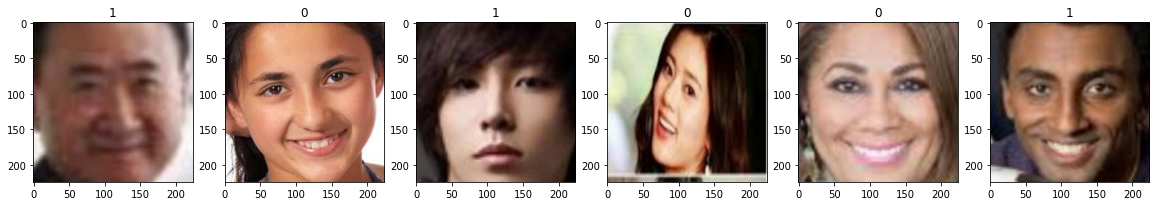

In [34]:
import matplotlib.pyplot as plt
import random

rid = random.choices(np.arange(face_img.shape[0]), k=25)

plt.figure(figsize=(20,6))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(face_img[rid[i]])
    plt.title(face_cate[rid[i]])

plt.show()

In [35]:
"""Split to train & val"""
from sklearn.model_selection import train_test_split

x_tra, x_val, y_tra, y_val = train_test_split(face_img, face_cate, test_size=0.1)
print(x_tra.shape, x_val.shape, y_tra.shape, y_val.shape)

(8544, 224, 224, 3) (950, 224, 224, 3) (8544,) (950,)


In [36]:
"""Data generator"""
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.utils import to_categorical

def data_generator(x_input, y_input, batch_size):
    n = x_input.shape[0]
    i = 0
    
    while True:
        image_data = []
        class_data = []
        
        for b in range(batch_size):
            if i==0:
                rid = np.arange(n)
                np.random.shuffle(rid)
            
            img = x_input[rid[i]]
            # caffe normalization
            img = preprocess_input(img)
            image_data.append(img)

            cls = y_input[rid[i]]
            # one hot encoding
            cls = to_categorical(cls, num_classes=2)
            class_data.append(cls)

            i = (i+1) % n
        
        image_data = np.array(image_data)
        class_data = np.array(class_data)

        yield image_data, class_data


# Training

In [37]:
BATCH_SIZE = 32

data_gen_tra = data_generator(x_tra, y_tra, BATCH_SIZE)
data_gen_val = data_generator(x_val, y_val, BATCH_SIZE)

In [38]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

gender_model.compile(loss=CategoricalCrossentropy(),
                     optimizer=Adam(),
                     metrics=['accuracy'])

path = 'drive/My Drive/Colab Notebooks/tibame_project/gender_identifying/gender_resnet50_haar.h5'

callbacks = [
    ModelCheckpoint(path, save_best_only=True),
    EarlyStopping(patience=6, restore_best_weights=True)
]

gender_model.fit_generator(
    data_gen_tra,
    epochs=64,
    steps_per_epoch=x_tra.shape[0]//BATCH_SIZE,
    callbacks=callbacks,
    validation_data=data_gen_val,
    validation_steps=x_val.shape[0]//BATCH_SIZE
)

Epoch 1/64
267/267 [==============================] - 56s 209ms/step - loss: 0.3654 - accuracy: 0.8543 - val_loss: 2.6099 - val_accuracy: 0.5356
Epoch 2/64
267/267 [==============================] - 53s 199ms/step - loss: 0.2222 - accuracy: 0.9107 - val_loss: 0.2805 - val_accuracy: 0.8847
Epoch 3/64
267/267 [==============================] - 50s 186ms/step - loss: 0.1848 - accuracy: 0.9264 - val_loss: 0.3440 - val_accuracy: 0.8491
Epoch 4/64
267/267 [==============================] - 50s 186ms/step - loss: 0.1635 - accuracy: 0.9355 - val_loss: 0.5037 - val_accuracy: 0.7877
Epoch 5/64
267/267 [==============================] - 53s 199ms/step - loss: 0.1482 - accuracy: 0.9384 - val_loss: 0.2146 - val_accuracy: 0.9149
Epoch 6/64
267/267 [==============================] - 50s 187ms/step - loss: 0.1403 - accuracy: 0.9462 - val_loss: 3.2374 - val_accuracy: 0.6466
Epoch 7/64
267/267 [==============================] - 50s 186ms/step - loss: 0.1231 - accuracy: 0.9521 - val_loss: 0.2913 - val_ac

In [39]:
model_name = 'gender_resnet50_haar'
gender_model.save('drive/My Drive/Colab Notebooks/tibame_project/gender_identifying/'+model_name)

INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/tibame_project/gender_identifying/gender_resnet50_haar/assets


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Text(0.5, 1.0, 'Female')

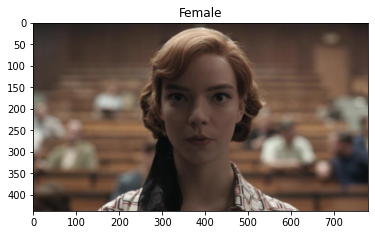

In [40]:
"""Test"""
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import cv2

# haarcascades
url = 'https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_alt2.xml'
urlretrieve(url, 'haarcascade_frontalface_alt2.xml')
hc  = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')

# test image
url = 'https://cdn.cnn.com/cnnnext/dam/assets/201025174835-a-chess-prodigy-story-in-the-queens-gambit-00012909-exlarge-169.jpg'
urlretrieve(url, 'Harmon.jpg')
img = cv2.imread('Harmon.jpg', 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# face detection
bbox = hc.detectMultiScale(img, minNeighbors=5, minSize=(10,10))

if bbox != ():
    # crop if success
    area = 0
    for x, y, w, h in bbox:
        if w*h > area:
            area = w*h
            (x_, y_, w_, h_) = (x, y, w, h)
    
    face_img = img[y_:y_+h_, x_:x_+w_] - 128.
    face_img = cv2.resize(face_img, (224,224)).reshape(1, 224, 224, 3)

# identifying
g = np.argmax(gender_model.predict(face_img))

plt.imshow(img)
plt.title(gender[g])
